# Classyfing the contributions

Based on the assumption, that certain keywords are linked to specific classes of contribution, this notebook aimes to use Machine Learning to assign a contribution class to the description of the contribution which can be found within the documents and in the future should be extracted with the help of Fonduer.

The following dataset was created manually by the Labelteam and transformed by Thorben for the purpose of ML. Every contribution is linked to a class_label.

In [1]:
import pandas as pd

data = pd.read_excel("./labeled_contribution_samples.xlsx")

data

,contribution,class_label
0,analysed data,Formal analysis
1,analysed experiments,Formal analysis
2,analysed the data collection,Formal analysis
3,analysed transcriptomic,Formal analysis
4,analyzed data,Formal analysis
...,...,...
194,wrote manuscript draft,Writing - original draft
195,wrote paper,Writing - original draft
196,wrote programm,Software
197,wrote R package for data fittting,Software


In [2]:
import numpy as np
label_dict = dict(enumerate(np.sort(data.class_label.unique()).flatten(),0))

There are 15 class labels available:

In [3]:
label_dict

{0: 'Conceptualization / Conceptualisation',
 1: 'Data curation',
 2: 'Formal analysis',
 3: 'Investigation',
 4: 'Methodology',
 5: 'Project administration',
 6: 'Resources',
 7: 'Software',
 8: 'Sonstiges',
 9: 'Supervision',
 10: 'Support',
 11: 'Validation',
 12: 'Visualization / Visualisation',
 13: 'Writing - original draft',
 14: 'Writing - review & editing'}

Assign a code to the respective class_labels

In [4]:
label_df = pd.DataFrame.from_dict(label_dict, orient = 'index', columns = ['class_label']).reset_index(names = 'label_code')

In [5]:
contributions_df = data.merge(label_df)

Shuffle the dataset.

In [6]:
contributions_df_shuffled = contributions_df.sample(frac=1).reset_index(drop=True)
contributions_df_shuffled

,contribution,class_label,label_code
0,assisted analysis,Formal analysis,2
1,discussed findings,Investigation,3
2,performed experimental work,Investigation,3
3,provided main text for the section,Writing - original draft,13
4,aquire data,Data curation,1
...,...,...,...
194,provided methods,Resources,6
195,implemented task,Sonstiges,8
196,gave final approval for publication,Supervision,9
197,assisted in conducting experiments,Investigation,3


Hot encoding of words in contribution

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

contributions_list = contributions_df_shuffled["contribution"].to_list()

# create a tokenizer, configured to only take the top N=1000 most common words
tokenizer = Tokenizer(num_words=1000)
# this builds the word index
tokenizer.fit_on_texts(contributions_list)

# this turns strings into lists of integer indices
sequences = tokenizer.texts_to_sequences(contributions_list)

# directly get the one-hot binary representation
one_hot_results = tokenizer.texts_to_matrix(contributions_list, mode='binary') 

# recover the word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 223 unique tokens.


Create datasets for training, validating and testing. 
  
70 % / 20 % / 10 %

In [8]:
from tensorflow.keras.utils import to_categorical

# where to slice the dataset:
train_size = int(round(0.7 * contributions_df_shuffled.shape[0],0))
val_size = int(round(0.2 * contributions_df_shuffled.shape[0],0))
test_size = int(round(0.1 * contributions_df_shuffled.shape[0],0))

# slice data
train_data = one_hot_results[:train_size]
val_data = one_hot_results[train_size:train_size + val_size]
test_data = one_hot_results[train_size+val_size:]

# slice labels
train_labels = to_categorical(contributions_df_shuffled.label_code)[:train_size]
val_labels = to_categorical(contributions_df_shuffled.label_code)[train_size:train_size + val_size]
test_labels = to_categorical(contributions_df_shuffled.label_code)[train_size+val_size:]

In [9]:
len(train_labels[0])

15

### Simple ANN model


Building a first really simple model

In [10]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()

model.add(layers.Dense(64, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(64, activation='relu', input_shape=(1000,)))
model.add(layers.Dense(15, activation='softmax'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Training the ANN for 20 epochs with batch_size=512 and use the history object.

In [11]:
history = model.fit(train_data,
                    train_labels,
                    epochs=20,
                    batch_size=512,
                    validation_data=(val_data, val_labels))

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.6916 - accuracy: 0.1295 - val_loss: 0.6805 - val_accuracy: 0.0750
Epoch 2/20
1/1 [==============================] - 0s 59ms/step - loss: 0.6791 - accuracy: 0.2014 - val_loss: 0.6717 - val_accuracy: 0.0750
Epoch 3/20
1/1 [==============================] - 0s 50ms/step - loss: 0.6692 - accuracy: 0.2230 - val_loss: 0.6629 - val_accuracy: 0.1500
Epoch 4/20
1/1 [==============================] - 0s 53ms/step - loss: 0.6594 - accuracy: 0.2374 - val_loss: 0.6537 - val_accuracy: 0.1500
Epoch 5/20
1/1 [==============================] - 0s 54ms/step - loss: 0.6491 - accuracy: 0.2662 - val_loss: 0.6438 - val_accuracy: 0.2000
Epoch 6/20
1/1 [==============================] - 0s 54ms/step - loss: 0.6382 - accuracy: 0.2590 - val_loss: 0.6331 - val_accuracy: 0.2000
Epoch 7/20
1/1 [==============================] - 0s 53ms/step - loss: 0.6265 - accuracy: 0.2878 - val_loss: 0.6216 - val_accuracy: 0.2250
Epoch 8/20
1/1 [=============

In [12]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Visualize the loss and accuracy by using pyplot.

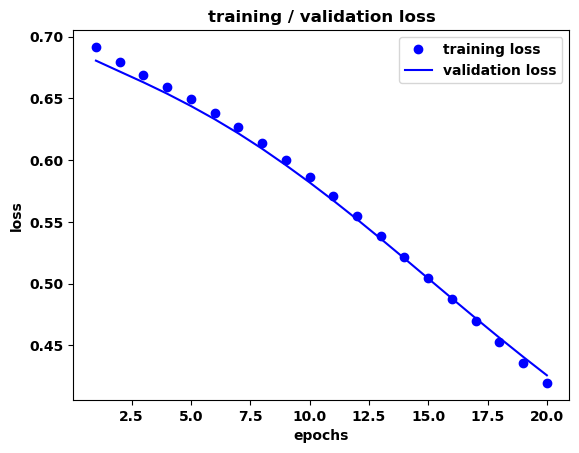

In [13]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training / validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

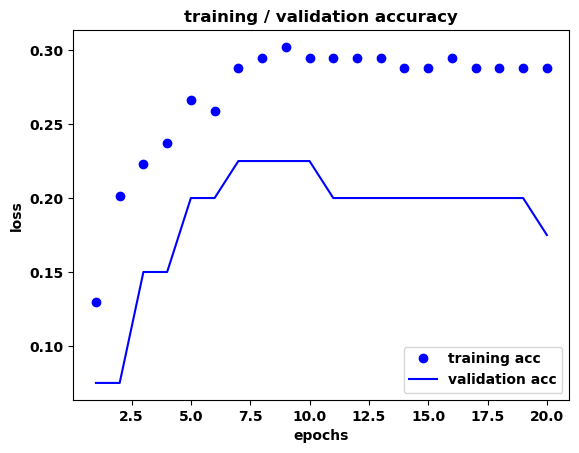

In [14]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training / validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy)
plt.legend()

plt.show()

In [15]:
results = model.evaluate(test_data, test_labels)

1/1 [==============================] - 0s 26ms/step - loss: 0.4299 - accuracy: 0.2500


In [16]:
results

[0.42987972497940063, 0.25]

The performance of this really simple model is not great, with an accuracy of 25 % for the test data. Lets add some parameter testing.

In [17]:
test_plan = {}
test_plan[0] = {"n_units": 32, "n_hidden_layers": 1}
test_plan[1] = {"n_units": 32, "n_hidden_layers": 2}
test_plan[2] = {"n_units": 32, "n_hidden_layers": 3}
test_plan[3] = {"n_units": 64, "n_hidden_layers": 1}
test_plan[4] = {"n_units": 64, "n_hidden_layers": 2}
test_plan[5] = {"n_units": 64, "n_hidden_layers": 3}
test_plan[6] = {"n_units": 128, "n_hidden_layers": 1}
test_plan[7] = {"n_units": 128, "n_hidden_layers": 2}
test_plan[8] = {"n_units": 128, "n_hidden_layers": 3}

In [18]:
result_dict = {}

for n in range(len(test_plan)):
    units = test_plan[n]["n_units"]
    hidden_layers = test_plan[n]["n_hidden_layers"]
    
    #initiate model
    model = models.Sequential()
    
    #add hidden layers
    if hidden_layers == 1:
        model.add(layers.Dense(units, activation='relu', input_shape=(1000,)))
    else:
        for i in range(hidden_layers):
            model.add(layers.Dense(units, activation='relu', input_shape=(1000,)))

    # add output layer
    model.add(layers.Dense(15, activation='softmax'))

    #compile model
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    #fit model
    model.fit(train_data,
              train_labels,
              epochs=10,
              batch_size=512,
              validation_data=(val_data, val_labels))

    results = model.evaluate(test_data, test_labels)
                               
    result_dict[n] = {"activation": "relu/softmax",  
                     "n_units": units, 
                     "n_hidden_layers": hidden_layers, 
                     "optimizer": "rmsprop", 
                     "loss": "binary_crossentropy",
                     "epochs": 10,
                     "batch_size": 512,
                     "accuracy": results[1]}

Epoch 1/10
1/1 [==============================] - 1s 893ms/step - loss: 0.6903 - accuracy: 0.1295 - val_loss: 0.6845 - val_accuracy: 0.1750
Epoch 2/10
1/1 [==============================] - 0s 61ms/step - loss: 0.6839 - accuracy: 0.1583 - val_loss: 0.6801 - val_accuracy: 0.1750
Epoch 3/10
1/1 [==============================] - 0s 92ms/step - loss: 0.6790 - accuracy: 0.1655 - val_loss: 0.6761 - val_accuracy: 0.2000
Epoch 4/10
1/1 [==============================] - 0s 54ms/step - loss: 0.6746 - accuracy: 0.1655 - val_loss: 0.6725 - val_accuracy: 0.1750
Epoch 5/10
1/1 [==============================] - 0s 57ms/step - loss: 0.6705 - accuracy: 0.1799 - val_loss: 0.6689 - val_accuracy: 0.1750
Epoch 6/10
1/1 [==============================] - 0s 50ms/step - loss: 0.6666 - accuracy: 0.2014 - val_loss: 0.6654 - val_accuracy: 0.2000
Epoch 7/10
1/1 [==============================] - 0s 51ms/step - loss: 0.6628 - accuracy: 0.2086 - val_loss: 0.6620 - val_accuracy: 0.2000
Epoch 8/10
1/1 [==========

Epoch 7/10
1/1 [==============================] - 0s 56ms/step - loss: 0.6290 - accuracy: 0.0576 - val_loss: 0.6173 - val_accuracy: 0.0750
Epoch 8/10
1/1 [==============================] - 0s 54ms/step - loss: 0.6133 - accuracy: 0.0576 - val_loss: 0.6010 - val_accuracy: 0.0750
Epoch 9/10
1/1 [==============================] - 0s 51ms/step - loss: 0.5963 - accuracy: 0.0576 - val_loss: 0.5835 - val_accuracy: 0.0750
Epoch 10/10
1/1 [==============================] - 0s 46ms/step - loss: 0.5690 - accuracy: 0.1000
Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.6911 - accuracy: 0.0288 - val_loss: 0.6797 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 49ms/step - loss: 0.6751 - accuracy: 0.0576 - val_loss: 0.6695 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 51ms/step - loss: 0.6633 - accuracy: 0.1079 - val_loss: 0.6605 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 53ms/

In [20]:
pd.DataFrame.from_dict(result_dict, orient = "index")

,activation,n_units,n_hidden_layers,optimizer,loss,epochs,batch_size,accuracy
0,relu/softmax,32,1,rmsprop,binary_crossentropy,10,512,0.15
1,relu/softmax,32,2,rmsprop,binary_crossentropy,10,512,0.05
2,relu/softmax,32,3,rmsprop,binary_crossentropy,10,512,0.35
3,relu/softmax,64,1,rmsprop,binary_crossentropy,10,512,0.10
4,relu/softmax,64,2,rmsprop,binary_crossentropy,10,512,0.05
5,relu/softmax,64,3,rmsprop,binary_crossentropy,10,512,0.10
6,relu/softmax,128,1,rmsprop,binary_crossentropy,10,512,0.00
7,relu/softmax,128,2,rmsprop,binary_crossentropy,10,512,0.00
8,relu/softmax,128,3,rmsprop,binary_crossentropy,10,512,0.25


Also the other tested configurations are not performing well.

## GloVE Approach

Processing Embeddings

In [22]:
import os
glove_dir = './GitHub/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors' % len(embeddings_index))

Found 400000 word vectors


Now, build an embedding matrix that can be loaded into an `Embedding` layer. It must be a matrix of shape `(max_words,embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index (built during tokenization). Note that the index `0` is not supposed to stand for any word or token. It is simply a placeholder.

In [25]:
max_words = len(word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in the embedding index will be all-zeros
            embedding_matrix[i] = embedding_vector

Building a model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

maxlen = 1000

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(15, activation='sigmoid'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 100)         22400     
                                                                 
 flatten_2 (Flatten)         (None, 100000)            0         
                                                                 
 dense_34 (Dense)            (None, 64)                6400064   
                                                                 
 dense_35 (Dense)            (None, 15)                975       
                                                                 
Total params: 6,423,439
Trainable params: 6,423,439
Non-trainable params: 0
_________________________________________________________________


loading the embeddings into the model

In [34]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

train model

In [35]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_data, train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(val_data, val_labels))

Epoch 1/10
5/5 [==============================] - 1s 135ms/step - loss: 0.5921 - acc: 0.2374 - val_loss: 0.4211 - val_acc: 0.5000
Epoch 2/10
5/5 [==============================] - 0s 44ms/step - loss: 0.3503 - acc: 0.5755 - val_loss: 0.3151 - val_acc: 0.6000
Epoch 3/10
5/5 [==============================] - 0s 43ms/step - loss: 0.2354 - acc: 0.7770 - val_loss: 0.2622 - val_acc: 0.6250
Epoch 4/10
5/5 [==============================] - 0s 52ms/step - loss: 0.1711 - acc: 0.8705 - val_loss: 0.2304 - val_acc: 0.6250
Epoch 5/10
5/5 [==============================] - 0s 59ms/step - loss: 0.1298 - acc: 0.9281 - val_loss: 0.2097 - val_acc: 0.6750
Epoch 6/10
5/5 [==============================] - 0s 36ms/step - loss: 0.1012 - acc: 0.9424 - val_loss: 0.1945 - val_acc: 0.6750
Epoch 7/10
5/5 [==============================] - 0s 58ms/step - loss: 0.0803 - acc: 0.9496 - val_loss: 0.1831 - val_acc: 0.6750
Epoch 8/10
5/5 [==============================] - 0s 65ms/step - loss: 0.0647 - acc: 0.9640 - va

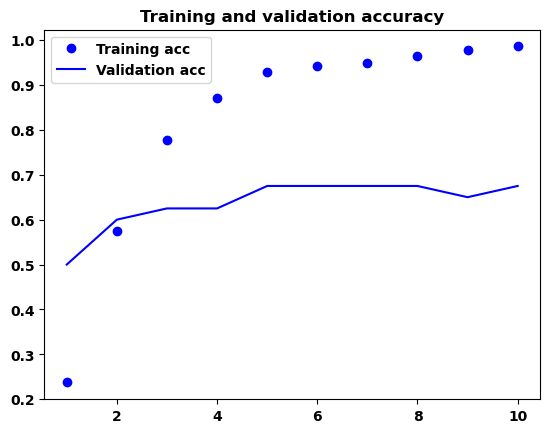

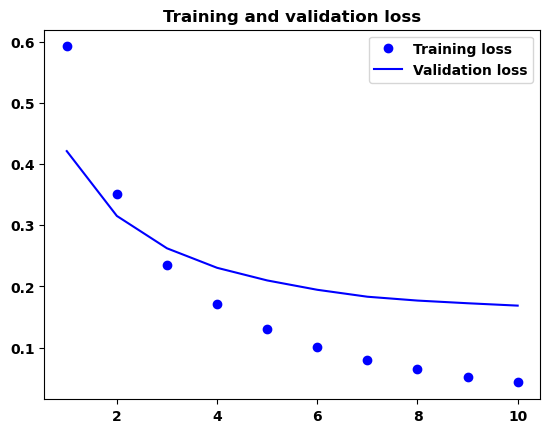

In [36]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [37]:
model.evaluate(test_data, test_labels)

1/1 [==============================] - 0s 29ms/step - loss: 0.1624 - acc: 0.6000


[0.16236309707164764, 0.6000000238418579]

The Glove Approach is performing a lot better than the previous approach, reaching an accuracy of 60 % for the test data.

Next steps in continuing with classyfing the contributions could be:

- Clustering via Embeddings (nearest neighbour)
- Add wrong contributions and additional "non-sense" classes for a more diverse dataset.